# Cooking LDA with recipes

In thematic modeling, it is assumed that the order of words in the document is not important for determining the subject (“bag of words”). We will work with a somewhat non-standard for thematic modeling collection, which can be called the “bag of ingredients”, because it consists of recipes from different cuisines. Thematic models are looking for words that are often found together in documents and make up topics. We will try to apply this idea to recipes and find culinary “themes”. This collection is good because it does not require preprocessing. In addition, it illustrates the principle of thematic models quite clearly.

##### Warning:
Building models takes some time. On Intel Core i7, 2400 MHz, it takes less than 10 minutes to build one model.

### Data loading 

In [1]:
import json

In [2]:
with open("recipes.json") as f:
    recipes = json.load(f)

In [4]:
recipes[0]

{'id': 10259,
 'cuisine': 'greek',
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

In [7]:
len(recipes)

39774

### Corpus building

In [9]:
import warnings
warnings.simplefilter('ignore')

from gensim import corpora, models
import numpy as np

In [10]:
texts = [recipe["ingredients"] for recipe in recipes]
dictionary = corpora.Dictionary(texts)   # compile a dictionary
corpus = [dictionary.doc2bow(text) for text in texts]  # prepare the corpus of documents

In [11]:
corpus[10]

[(0, 1),
 (3, 1),
 (5, 1),
 (59, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 1)]

The element of corpus is a list of pairs (ingredient_id, count_in_the_recipe)
У объекта dictionary есть полезная переменная dictionary.token2id, позволяющая находить соответствие между ингредиентами и их индексами.

### Model learning

Let's try the LDA model with 40 topics.

In [13]:
np.random.seed(76543)
%time first_lda_model = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=40, passes=5)

Wall time: 1min 10s


In [14]:
first_lda_model.save('first_lda_model_xkcd')

In [13]:
first_lda_model = models.ldamodel.LdaModel.load('first_lda_model_xkcd')

Quick look at top words of each topic.

In [21]:
x = first_lda_model.show_topics(num_topics=40, num_words=10, formatted=False)

topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

for topic, words in topics_words:
    print(str(topic) + ": " + str(words))
print()

How many times can we see "salt", "sugar", "water", "mushrooms", "chicken", "eggs" among tops-10 of all 40 topics?

In [24]:
counts = {'salt': 0, 'sugar': 0, 'water': 0, 'mushrooms': 0, 'chicken': 0, 'eggs': 0}
for topic in topics_words:
    for word in counts.keys():
        if word in topic[1]:
            counts[word] = counts[word] + 1

In [25]:
counts

{'salt': 23, 'sugar': 9, 'water': 10, 'mushrooms': 0, 'chicken': 1, 'eggs': 2}

### Dictionary filtering
In the tops, the first three ingredients are much more common than the last three. At the same time, the presence of chicken, eggs or mushrooms in the recipe gives more information about the dish than the presence of salt, sugar and water. Thus, even in recipes there are words that don't carry a semantic load, and therefore it isn't desirable to see them in topics. The easiest way to deal with such background elements is to filter the dictionary by frequency. Usually, the dictionary is filtered from two sides: very rare words are removed (in order to save memory) and very frequent words (in order to increase the interpretability of topics). We will remove only frequent words.

In [27]:
import copy
dictionary_filtered = copy.deepcopy(dictionary)

Let's remove ingredients that appear in our cuisine collection more than 4000 times and look at size changes of dictionary and corpus.

In [28]:
dict_size_before = len(dictionary_filtered)
corpus_size_before = sum([len(recipe) for recipe in corpus])

In [29]:
print('Dictionary size before the removing:', dict_size_before)
print('Corpus size before the removing:', corpus_size_before)

Dictionary size before the removing: 6714
Corpus size before the removing: 428249


In [38]:
most_popular = []
for k, v in zip(dictionary_filtered.dfs.keys(), dictionary_filtered.dfs.values()):
    if v > 4000:
        most_popular.append(k)

In [39]:
for i in most_popular:
    print(dictionary_filtered[i], dictionary_filtered.dfs[i])

garlic 7380
pepper 4438
salt 18048
ground black pepper 4784
vegetable oil 4385
butter 4847
water 7457
onions 7972
sugar 6434
olive oil 7971
garlic cloves 6236
all-purpose flour 4632


In [40]:
dictionary_filtered.filter_tokens(most_popular)

In [41]:
dict_size_after = len(dictionary_filtered)
corpus_filtered = [dictionary_filtered.doc2bow(text) for text in texts]
corpus_size_after = sum([len(recipe) for recipe in corpus_filtered])

In [42]:
print('Dictionary size after the removing:', dict_size_after)
print('Corpus size after the removing:', corpus_size_after)

Dictionary size after the removing: 6702
Corpus size after the removing: 343665


So, we have decreased the corpus size on nearly 20 percents by removing 12 common ingredients.

### Coherence comparison

Topic Coherence - pointwise mutual information of top words of the topic. This measure shows, how often words that appear together in texts, appear in the tops of the same topics. We will calculate the mean of topic coherences of both models.

In [43]:
np.random.seed(76543)
%time second_lda_model = models.ldamodel.LdaModel(corpus_filtered, id2word=dictionary_filtered, num_topics=40, passes=5)

In [ ]:
second_lda_model.save('second_lda_model_xkcd')

In [ ]:
second_lda_model = models.ldamodel.LdaModel.load('second_lda_model_xkcd')

In [44]:
first_coherence = np.mean([topic[1] for topic in first_lda_model.top_topics(corpus)])
second_coherence = np.mean([topic[1] for topic in second_lda_model.top_topics(corpus_filtered)])
print(first_coherence)
print(second_coherence)

-5.804997312362428
-8.307382309049668


It is believed that the coherence correlates well with human assessments of interpretability of topics. Therefore, on large text collections, coherence usually increases if the background vocabulary is removed. However, this hasn't happened in our case.

### Exploring effects of the alpha hyperparameter

So far we have only looked at the topic-word matrix, now let's look at the document-topic matrix.

In [46]:
second_lda_model.get_document_topics(corpus_filtered[0])

[(25, 0.128125), (30, 0.13393019), (31, 0.6223198)]

So, can see that document is described mainly by three topics.

__Alpha__ parameter of the second_lda_model:

In [47]:
second_lda_model.alpha

array([0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025], dtype=float32)

Let's try to change the __alpha__ hyperparameter, which defines the Dirichlet priori distribution for the distribution of topics in documents.

In [48]:
np.random.seed(76543)
%time third_lda_model = models.ldamodel.LdaModel(corpus_filtered, id2word=dictionary_filtered, passes=5, alpha=1)

In [ ]:
third_lda_model.save('third_lda_model_xkcd')

In [ ]:
third_lda_model = models.ldamodel.LdaModel.load('third_lda_model_xkcd')

In [49]:
third_lda_model.get_document_topics(corpus_filtered[0])

[(30, 0.019214524),
 (31, 0.019030767),
 (34, 0.0189094),
 (61, 0.018693281),
 (72, 0.018829131),
 (94, 0.018750459)]

Can see, that the distribution over a variety of topics is almost uniform.

To make sure that in the second model, the documents are described by much more sparse distributions than in the third, we will calculate the total number of elements that exceed 0.01, in the matrices of the subject-documents of both models.

In [51]:
count_for_model_2, count_for_model_3 = 0, 0
for i in range(len(corpus_filtered)):
    doc_topics_model_2 = second_lda_model.get_document_topics(corpus_filtered[i], minimum_probability=0.01)
    count_for_model_2 += len(doc_topics_model_2)
    doc_topics_model_3 = third_lda_model.get_document_topics(corpus_filtered[i], minimum_probability=0.01)
    count_for_model_3 += len(doc_topics_model_3)

In [52]:
print('The total number of elements that exceed 0.01 for model 2:', count_for_model_2)
print('The total number of elements that exceed 0.01 for model 3:', count_for_model_3)

The total number of elements that exceed 0.01 for model 2: 198358
The total number of elements that exceed 0.01 for model 3: 453952


Thus, the __alpha__ hyperparameter affects the sparsity of topic distributions in documents. Similarly, the __eta__ hyperparameter affects the sparsity of word distributions in topics.

### LDA as a way to reduce the dimension
Sometimes, distributions over topics that have found using LDA, add to the matrix as additional, semantic features, and this can improve the quality of problem solving. For simplicity, let's just teach the recipe classifier on features obtained from the LDA, and measure the accuracy.


__Задание 5.__ Используйте модель, построенную по сокращенной выборке с alpha по умолчанию (вторую модель). Составьте матрицу $\Theta = p(t|d)$ вероятностей тем в документах; вы можете использовать тот же метод get_document_topics, а также вектор правильных ответов y (в том же порядке, в котором рецепты идут в переменной recipes). Создайте объект RandomForestClassifier со 100 деревьями, с помощью функции cross_val_score вычислите среднюю accuracy по трем фолдам (перемешивать данные не нужно) и передайте в функцию save_answers5.

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [54]:
X, y = [], []
for i in range(len(corpus_filtered)):
    X.append([prob for topic, prob in second_lda_model.get_document_topics(corpus_filtered[i], minimum_probability=0)])
    y.append(recipes[i]['cuisine'])

In [55]:
rf = RandomForestClassifier(n_estimators=100)

In [56]:
np.mean(cross_val_score(estimator=rf, X=X, y=y, cv=3, n_jobs=-1))

0.5519439194273451

In [58]:
np.unique(y)

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype='<U12')

For such number of classes, this is a good accuracy. Thus, the LDA didn't collect all, but rather a large part of the information from the sample, in a low rank matrix.

### LDA — probabilistic model
The matrix decomposition used in LDA is interpreted as the following document generation process.

For document $d$ with length $n_d$:
1. From the Dirichlet prior distribution with the alpha parameter, generate the distribution over the set of topics: $\theta_d \sim Dirichlet(\alpha)$
1. For each word $w = 1, \dots, n_d$:
    1. Generate topic from discrete distribution $t \sim \theta_{d}$
    1. Generate a word from a discrete distribution $w \sim \phi_{t}$.
    
More on [wiki](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).

In the context of our task, it turns out that using this generative process, you can create new recipes. You can transfer the model and the number of ingredients to the function and generate a recipe :)

In [59]:
def generate_recipe(model, num_ingredients):
    theta = np.random.dirichlet(model.alpha)
    for i in range(num_ingredients):
        t = np.random.choice(np.arange(model.num_topics), p=theta)
        
        topic = model.show_topic(t, topn=model.num_terms)
        topic_distr = [x[1] for x in topic]
        topic_distr = np.array(topic_distr) / np.sum(topic_distr)   #for getting around the numpy issue
                                                                    #about a sum of small values    
                                                                    #e.g. 0.3 - 0.1 - 0.1 - 0.1 != 0
        terms = [x[0] for x in topic]
        
        w = np.random.choice(terms, p=topic_distr)
        print (w)

In [60]:
generate_recipe(second_lda_model, 10)

dried shiitake mushrooms
corn husks
mild cheddar cheese
shelled pistachios
chicken
dried shiitake mushrooms
masa harina
hard-boiled egg
chicken bouillon granules
lime rind


### Interpretation of the constructed model
We can look at the tops of the ingredients of each topic. Most topics are similar to recipes; some collect products of the same type, for example, fresh fruits or different types of cheese.

Let us try to correlate our topics with the national cuisines. We construct the matrix $A$, in which the rows are topics, and the columns are different cuisines; its elements $a_ {tc}$ are sums of $p(t | d)$ for all documents $d$ that are assigned to the cuisine $c$. We normalize the matrix in order to avoid an imbalance between cuisines. The following function takes the model object, the corpus object and the source data as input, and returns the normalized $A$ matrix. It is convenient to visualize it using seaborn.

In [48]:
import pandas
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [49]:
def compute_topic_cuisine_matrix(model, corpus, recipes):
    targets = list(set([recipe["cuisine"] for recipe in recipes]))
    
    tc_matrix = pandas.DataFrame(data=np.zeros((model.num_topics, len(targets))), columns=targets)
    for recipe, bow in zip(recipes, corpus):
        recipe_topic = model.get_document_topics(bow)
        for t, prob in recipe_topic:
            tc_matrix[recipe["cuisine"]][t] += prob
    
    target_sums = pandas.DataFrame(data=np.zeros((1, len(targets))), columns=targets)
    for recipe in recipes:
        target_sums[recipe["cuisine"]] += 1
        
    return pandas.DataFrame(tc_matrix.values/target_sums.values, columns=tc_matrix.columns)

In [50]:
def plot_matrix(tc_matrix):
    plt.figure(figsize=(10, 10))
    seaborn.heatmap(tc_matrix, square=True)

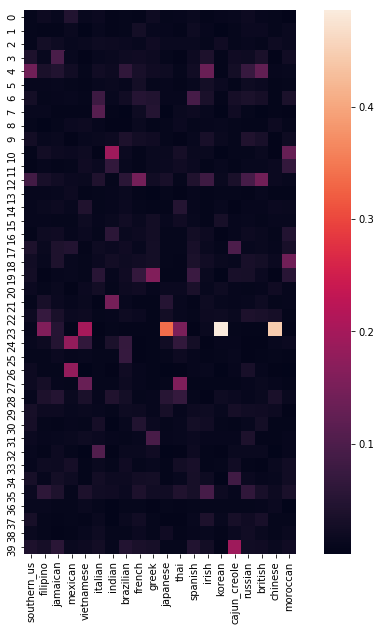

In [51]:
plot_matrix(compute_topic_cuisine_matrix(second_lda_model, corpus_filtered, recipes))

The lighter the square in the matrix, the greater the connection of this topic with this cuisine. We see that we have topics that are related to several cuisines. Such topics show sets of ingredients that are popular in the cuisines of several nations, that is, indicate the similarity of the cuisines. Some topics are distributed across cuisines evenly; they show sets of ingredients that are often used in cooking in all countries.